In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from scipy.linalg import eigh
from sklearn.datasets import make_circles

In [2]:
class KPCA():
    def __init__(self, kernel, n_components=None, gamma=None, degree=3, coef0=1):
        self.kernel = kernel
        self.n_components = n_components
        self.gamma  = gamma
        self.degree = degree
        self.coef0  = coef0
                
    def squared_euclidean_dist(self, X):
        XX = np.linalg.norm(X, axis=1)
        XX = np.square(XX)[:,np.newaxis]
        dist = XX+XX.T-2*np.dot(X,X.T)
        np.fill_diagonal(dist, 0)        
        return dist
        
    def compute_kernel(self, X):       
        if(self.kernel == 'linear'):            
            # K(x, y) = <X, Y>
            
            K = np.dot(X, X.T)
            return K
        
        elif(self.kernel == 'poly'):            
            # K(X, Y) = (gamma <X, Y> + coef0)^degree
            
            if(self.gamma==None):
                self.gamma=1.0/X.shape[1]
            K = np.dot(X, X.T)
            K *= self.gamma
            K += self.coef0
            K **= self.degree
            return K
        
        elif(self.kernel == 'rbf'):           
            # K(x, y) = exp(-gamma ||x-y||^2)
            
            if(self.gamma==None):
                self.gamma=1/X.shape[1]
            K = self.squared_euclidean_dist(X)
            K *= -self.gamma
            K = np.exp(K)
            return K       
        
    def kernel_centering(self, K):
        K_row = (np.sum(K, axis=0)/K.shape[0])[np.newaxis,:]
        K_col = (np.sum(K, axis=1)/K.shape[0])[:,np.newaxis]
        K_all = np.sum(K)/np.square(K.shape[0])
        K_center = K - K_row - K_col + K_all
        return K_center
        
    def transform(self, X):
        K = self.compute_kernel(X)
        K = self.kernel_centering(K)
        lambdas, alphas = eigh(K)
        alphas  = alphas/lambdas
        
        indices = lambdas.argsort()[::-1]
        lambdas = lambdas[indices]
        alphas  = alphas[:,indices]        
        
        X_new = alphas * lambdas
        
        return X_new

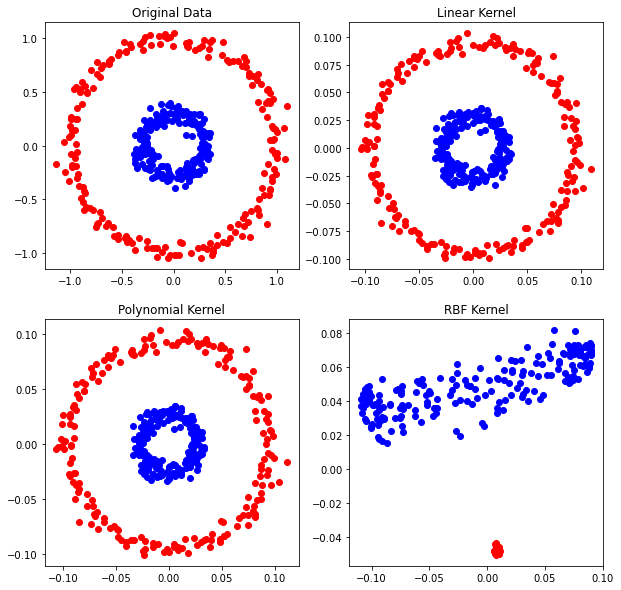

In [3]:
X, y = make_circles(n_samples=400, noise=0.05, factor=0.3, random_state=1)
reds = y==0
blues = y==1 

kernel = ['linear','poly','rbf']

kpca_linear = KPCA(kernel='linear')
X_new_linear = kpca_linear.transform(X)
X_new_linear = X_new_linear[:,:2]

kpca_poly = KPCA(kernel='poly')
X_new_poly = kpca_poly.transform(X)
X_new_poly = X_new_poly[:,:2]

kpca_rbf = KPCA(kernel='rbf', gamma=10)
X_new_rbf = kpca_rbf.transform(X)
X_new_rbf = X_new_rbf[:,:2]

X_new_kernel = [X, X_new_linear, X_new_poly, X_new_rbf]
title = ['Original Data', 'Linear Kernel', 'Polynomial Kernel', 'RBF Kernel']

fig, axes = plt.subplots(2,2,figsize=(10,10))
axes = np.reshape(axes, -1)
for i, ax in enumerate(axes):
    X_new = X_new_kernel[i]
    ax.scatter(X_new[reds,0], X_new[reds,1], c='r')
    ax.scatter(X_new[blues,0], X_new[blues,1], c='b')
    ax.set_title(title[i])